# HomeWork

과제는 다음과 같습니다.

1. 이미지 최종 embedding size 맞도록 계산 및 코드 수정하기
2. 좋은 성능이 나오도록 자유롭게 Resnet Fine tunning 실험해보기

##1. Image Size 수정

앞선 수업코드에서는 ResNet 본래의 input size인 224를 맞추기 위해 Resize와 Crop을 사용하였습니다.

그러나 resize와 crop을 거친 이미지는 원본의 특징을 정확하게 반영하지 못할 가능성이 있습니다. 

따라서 아래의 식을 이용해 ResNet18이 우리의 input image size를 받고도 작동하도록 모델을 바꿔주세요

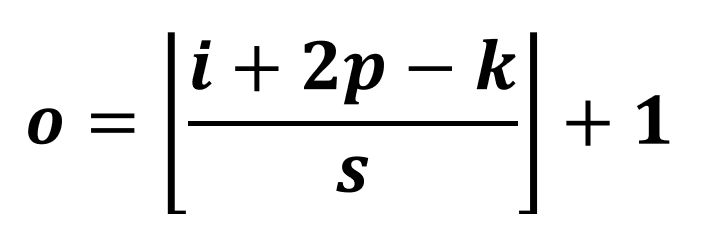

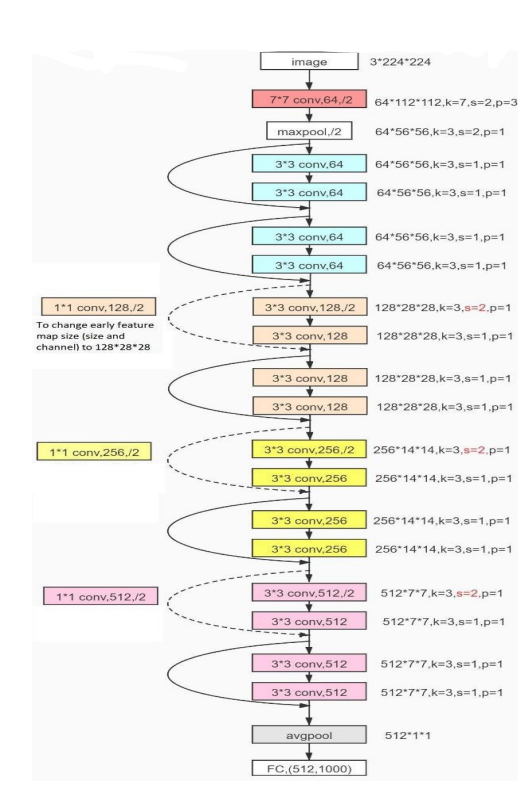

즉, 224*224가 아닌,

 우리의 이미지 크기 64*64가 ResNet으로 들어가 

 최종 layer에서 7*7의 차원을 갖도록 output size를 조절해가며 stride, padding 및 kernel size등을 조정해 보시면 됩니다.

**이 부분에 어떻게 stride, padding등을 바꿔서 최종 7*7을 만들었는지 서술 해 주세요**

## 2. 성능 높이기

Resnet의 layer4 부분까지 fine-tunning 해 주세요

여러 hyperparameter들은 자유롭게 변경해가며 본인만의 ResNet을 만들어 보세요

## 3. 코드 구현 부분

In [1]:
## 필요한 모듈 import

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision 
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import numpy as np
import time
import copy

In [2]:
# Pre-trained ResNet 가져오기
Resnet = torchvision.models.resnet18(pretrained=True) # 해당 부분을 False로 바꾸면 구조만 가져온다

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [3]:
# ResNet18의 layer이름을 확인 ( 이후 layer 고칠 때 찾기 쉬우라고 함 )
for name,child in Resnet.named_children(): 
  print('Layer Name : ',name) # 각 layer의 이름 확인
  print('Layer Info. : ',child) # 각 layer의 정보 확인
  print()

Layer Name :  conv1
Layer Info. :  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

Layer Name :  bn1
Layer Info. :  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

Layer Name :  relu
Layer Info. :  ReLU(inplace=True)

Layer Name :  maxpool
Layer Info. :  MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

Layer Name :  layer1
Layer Info. :  Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
## 데이터셋 로드 
from torchvision.datasets import ImageFolder
import os
#!unzip -qq "/content/drive/MyDrive/22-2DSL/[0825] CNN_Implementation/face_dataset.zip"

data_dir = 'face_dataset'
path = {x: os.path.join('/content/drive/MyDrive/22-2DSL/[0825] CNN_Implementation/'+data_dir+'/facescrub_'+x) for x in ['train', 'test'] } # Train, Test 경로 지정
## local에 이미지를 저장했으면 저장한 경로만 찾아서 붙여넣어 주기
print(path)
train_data = ImageFolder(path['train'], transforms.Compose([transforms.ToTensor()]))

{'train': '/content/drive/MyDrive/22-2DSL/[0825] CNN_Implementation/face_dataset/facescrub_train', 'test': '/content/drive/MyDrive/22-2DSL/[0825] CNN_Implementation/face_dataset/facescrub_test'}


In [6]:
# Input Normalize 계산하는데 오래걸려서 미리 구해둠
avgR = 0.6565039 
avgG = 0.4843807
avgB = 0.4084822
stdR = 0.20245129
stdG = 0.17317267
stdB = 0.1622832

In [7]:
## 데이터 전처리를 위한 과정

data_transforms = {
    'facescrub_train': transforms.Compose([
        # 이미지 증강
        transforms.RandomHorizontalFlip(), # 수평으로 뒤집기
        transforms.RandomVerticalFlip(), # 수직으로 뒤집기
        # 이미지를 텐서로 변경
        transforms.ToTensor(),
        # Input 값 Normalize 해주기 ( 각 채널의 평균 값과 표준편차 값으로 정규화 해줌 )
        transforms.Normalize([avgR, avgG, avgB], [stdR, stdG, stdB])
    ]),
    # 위와 동일한 과정 Test set에 대해 진행하기
    'facescrub_test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([avgR, avgG, avgB], [stdR, stdG, stdB])
    ]),
}

In [8]:
## 앞서 정의한 data_transforms를 이용해 실제 train과 test 이미지셋을 만들어 준다
image_datasets = {x: datasets.ImageFolder(os.path.join('/content/drive/MyDrive/22-2DSL/[0825] CNN_Implementation/face_dataset/', x),
                                          data_transforms[x]) for x in ['facescrub_train', 'facescrub_test']}

In [9]:
## Train과 Testset의 크기 확인
data_sizes = {x: len(image_datasets[x]) for x in ['facescrub_train', 'facescrub_test']}
print(data_sizes['facescrub_train'])
print(data_sizes['facescrub_test'])

4000
1000


In [10]:
## Dataloader를 설정해 준다
dataloaders = {x: torch.utils.data.DataLoader(
                       image_datasets[x], batch_size=16, # 이 부분에서 batch_size를 설정할 수 있음 
                       shuffle=True, # train data를 batch로 묶을 때 섞을 것인지 결정
                       num_workers=2) # Dataloader가 data를 읽어들일 때 사용할 스레드의 개수 (GPU 사용량을 결정)
                                            for x in ['facescrub_train', 'facescrub_test']}
## class 이름 설정 
class_names = image_datasets['facescrub_train'].classes 

## 어떤 device를 이용할 것인지 결정한다 (gpu 불가능하면 cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
## 세 전이학습에 사용할 ResNet 각각 load
## Resnet을 불러와 주세요
Resnet_sample = torchvision.models.resnet18(pretrained=True)

In [12]:
# ResNet18의 layer이름을 확인 ( 이후 layer 고칠 때 찾기 쉬우라고 함 )
for name,child in Resnet.named_children(): 
  print('Layer Name : ',name) # 각 layer의 이름 확인
  print('Layer Info. : ',child) # 각 layer의 정보 확인
  print()

Layer Name :  conv1
Layer Info. :  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

Layer Name :  bn1
Layer Info. :  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

Layer Name :  relu
Layer Info. :  ReLU(inplace=True)

Layer Name :  maxpool
Layer Info. :  MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

Layer Name :  layer1
Layer Info. :  Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps

In [ ]:
## Resnet의 output layer를 우리의 이미지에 맞도록 크기조정 해 주세요
## 단, kernel size를 바꿀 경우 가중치의 개수가 달라지므로 Fine-Tunning 시 해당 layer도 넣어서 해주셔야 합니다!
## stride를 조작해 보시는 것을 추천드립니다

In [13]:
## 해당 코드는 참조 코드입니다.
## 해당 cell을 실행시키면 Resnet 의 layer3의 conv1, downsample과 layer4의 conv1, downsample의 stride가 변경됩니다.
Resnet.layer3[0].conv1.stride = (1, 1)
Resnet.layer3[0].downsample[0].stride = (1, 1)
Resnet.layer4[0].conv1.stride = (1, 1)
Resnet.layer4[0].downsample[0].stride = (1, 1)

In [14]:
# 변경된 정보를 확인해 보세요
for name,child in Resnet.named_children(): 
  print('Layer Name : ',name) 
  print('Layer Info. : ',child) 
  print()

Layer Name :  conv1
Layer Info. :  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

Layer Name :  bn1
Layer Info. :  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

Layer Name :  relu
Layer Info. :  ReLU(inplace=True)

Layer Name :  maxpool
Layer Info. :  MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

Layer Name :  layer1
Layer Info. :  Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps

In [15]:
from torchsummary import summary as summary_
summary_(Resnet_sample.cuda(),(3,64,64),batch_size=16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [16, 64, 32, 32]           9,408
       BatchNorm2d-2           [16, 64, 32, 32]             128
              ReLU-3           [16, 64, 32, 32]               0
         MaxPool2d-4           [16, 64, 16, 16]               0
            Conv2d-5           [16, 64, 16, 16]          36,864
       BatchNorm2d-6           [16, 64, 16, 16]             128
              ReLU-7           [16, 64, 16, 16]               0
            Conv2d-8           [16, 64, 16, 16]          36,864
       BatchNorm2d-9           [16, 64, 16, 16]             128
             ReLU-10           [16, 64, 16, 16]               0
       BasicBlock-11           [16, 64, 16, 16]               0
           Conv2d-12           [16, 64, 16, 16]          36,864
      BatchNorm2d-13           [16, 64, 16, 16]             128
             ReLU-14           [16, 64,

In [16]:
seq_train_loss = []
seq_test_loss = []
seq_train_acc = []
seq_test_acc = []

In [25]:
## Train 함수 정의

def train(model,epoch,optimizer,criterion,scheduler=None,save_every=None):
    ## 각 단계의 loss 및 accuracy 저장할 list 생성

    print(f'\n[ Train epoch: {epoch+1} ]')

    model.train() # Train 단계임을 선업

    running_loss = 0.0
    batch_losses = []
    total = 0
    correct = 0

    for batch_idx, (inputs, targets) in enumerate(dataloaders['facescrub_train']): # Train data 가져오기
        inputs, targets = inputs.to(device), targets.to(device) # dataloader의 input image와 label도 device에 넣어준다
        if len(optimizer) != 1:
          optimizer[0].zero_grad()
          optimizer[1].zero_grad()
        else:
          optimizer.zero_grad() # gradient 초기화
        outputs = model(inputs) # Prediction value 계산 (Output 계산)
        loss = criterion(outputs, targets) # outputs와 원래 label인 targets 사이 loss 계산
        loss.backward() # 계산한 loss 기반으로 gradient 값 계산
        if len(optimizer) != 1:
          optimizer[0].step() # weight parameter update
          optimizer[1].step()
        else:
          optimizer.step()
        if scheduler :
          scheduler.step()

        total += targets.size(0) # batch 데이터 개수 더하기
        running_loss += loss.item()
        batch_losses.append(loss.item())
        
        _, predicted = outputs.max(1) # 확률값 가장 높게 나타난 클래스
        correct += (predicted == targets).sum().item() # 현재 batch 내에서 알맞게 분류한 이미지 개수 더하기
        
        if batch_idx % 50 == 49:
            ## 학습 중간 성능 확인
            print(f'\nCurrent batch: {str(batch_idx+1)}')
            print(f'Average train loss of recent 50 batches: {running_loss / 49}') 
            running_loss = 0.0

    if save_every :
      if (epoch % save_every == 0): # 얼마만큼의 iteration마다 저장할 것인지를 설정
          directory = os.path.join(save_path, 'Resnet') # 경로 설정
          if not os.path.exists(directory): # 경로가 없다면 새로 만듦
              os.makedirs(directory)
          if len(optimizer) != 0:
            torch.save({ 
                # 학습 중간에 저장하려 하는 모든 것들을 dict로 서술
                'epoch': epoch, 
                'iteration': batch_idx,
                'model': model.state_dict(),
                'opt1': optimizer[0].state_dict(),
                'opt2': optimizer[1].state_dict(),
                'loss': loss
                #,'sch': scheduler.state_dict()
                }, os.path.join(directory, '{}ep_{}iter_{}_A.tar'.format(epoch,batch_idx,'checkpoint')))
          else:
            torch.save({ 
              # 학습 중간에 저장하려 하는 모든 것들을 dict로 서술
              'epoch': epoch, 
              'iteration': batch_idx,
              'model': model.state_dict(),
              'opt': optimizer.state_dict(),
              'loss': loss
              #,'sch': scheduler.state_dict()
              }, os.path.join(directory, '{}ep_{}iter_{}_A.tar'.format(epoch,batch_idx,'checkpoint')))

    avg_loss = sum(batch_losses) / len(batch_losses)
    seq_train_loss.append(avg_loss)
    seq_train_acc.append(100*correct/total)
    print('\nTotal train accuarcy:', 100. * correct / total) # 전체 데이터 개수에서 맞게 예측한 비율
    print('Total train loss:', avg_loss)

In [26]:
def test(model,epoch,criterion):
    print(f'\n[ Test epoch: {epoch+1} ]')

    model.eval() # Test time임을 선언

    loss = 0
    batch_losses = []
    correct = 0
    total = 0

    with torch.no_grad(): # gradient update 안함 - eval과 torch.no_grad는 하나의 세트
        for batch_idx, (inputs, targets) in enumerate(dataloaders['facescrub_test']):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            batch_losses.append(loss.item())

            total += targets.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == targets).sum().item()

    avg_loss = sum(batch_losses) / len(batch_losses)
    seq_test_loss.append(avg_loss)
    seq_test_acc.append(100 * correct / total)
    print('\nTest accuarcy:', 100. * correct / total)
    print('Test average loss:', avg_loss)

In [27]:
## fine-tunning 하고싶은 부분을 제외하고 update를 얼려 주세요
for name,child in Resnet_sample.named_children():
  for param in child.parameters():
    if name not in ['layer4', 'fc']:   # 'fc' 이름의 layer만 제외
      #'여기에 기울기 업데이트를 얼리는 코드를 넣어주세요'
      param.requires_grad = False

In [28]:
## 지정한 device에 학습시킬 모델 얹어주기
Resnet_sample.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
## Optimizer, Scheduler, Cost Function 등을 직접 설정해서 사용해 보세요
optimizer_retrain = optim.SGD(params=Resnet_sample.fc.parameters(),lr=0.01)
optimizer_fine_tune = optim.SGD(params=Resnet_sample.layer4.parameters(),lr=0.001)
optimizer = [optimizer_retrain,optimizer_fine_tune]
scheduler = None
criterion = nn.CrossEntropyLoss()

In [30]:
num_epochs = 10

In [31]:
## Checkpoint를 저장할 경로를 설정해 주세요
save_path = '/content/drive/MyDrive/22-2DSL/[0825] CNN_Implemetation/Resnet'

In [ ]:
## 학습을 진행해 주세요 (GPU로 돌려야 합니다 CPU는 너무 느려요)
for epoch in range(0,num_epochs):
  train(Resnet_sample,epoch,optimizer,criterion,save_every=1)
  test(Resnet_sample,epoch,criterion)


[ Train epoch: 1 ]

Current batch: 50
Average train loss of recent 50 batches: 12.342714329155124

Current batch: 100
Average train loss of recent 50 batches: 9.905535941221276

Current batch: 150
Average train loss of recent 50 batches: 8.549730670695402

Current batch: 200
Average train loss of recent 50 batches: 7.363208527467688

Current batch: 250
Average train loss of recent 50 batches: 6.800900634454221

Total train accuarcy: 1.425
Total train loss: 8.812569660186767

[ Test epoch: 1 ]

Test accuarcy: 5.0
Test average loss: 6.056506338573637

[ Train epoch: 2 ]

Current batch: 50
Average train loss of recent 50 batches: 5.725459118278659

Current batch: 100
Average train loss of recent 50 batches: 5.210441316877093

Current batch: 150
Average train loss of recent 50 batches: 4.871675544855546

Current batch: 200
Average train loss of recent 50 batches: 4.84027395929609

Current batch: 250
Average train loss of recent 50 batches: 4.497843581802991

Total train accuarcy: 7.65
Tot

In [ ]:
## 저장이 진행되었는지 확인해 보시고 성능 그래프를 그려주세요
plt.plot(range(num_epochs), seq_train_loss, label="Train loss")
plt.plot(range(num_epochs), seq_test_loss, label="Test loss")
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
plt.plot(range(num_epochs), seq_train_acc['Resnet_2'], label="Train Accuracy")
plt.plot(range(num_epochs), seq_test_acc['Resnet_2'], label="Test Accuracy")
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

수고하셨습니다!